### final

In [1]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

# 법정동별 인스타그램 노출 수 가져오기
sql = 'select * from m1.instagram_emd_cnt'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_instagram = pd.DataFrame(rows)
df_instagram.columns = ['emd_nm','emd_cd','cnt','base_ym']
df_instagram['cnt'] = df_instagram['cnt'].astype(float)

# PNU별 유동인구 
sql = '''
select substring(bd_mgt_sn, 0, 20) as pnu, avg(f_tot)
  from m1.kt_bldg_xy_info
 where base_ym = '202209'
 group by substring(bd_mgt_sn, 0, 20)
'''
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_f_tot = pd.DataFrame(rows)
df_f_tot.columns = ['pnu','f_tot']
df_f_tot['emd_cd'] = df_f_tot['pnu'].str[:8] + '00'


# 데이터 프레임 병합
df = pd.merge(df_f_tot, df_instagram, on='emd_cd', how='left')

# 인구가 0, null 인 지역 제외
df = df[~df['cnt'].isnull()].reset_index(drop=True)

# 게시글 수 없는 지역 제외
idx_nm = df[(df['emd_nm']=='구호동') | (df['emd_nm']=='법성면') | (df['emd_nm']=='대소원면')].index
df = df.drop(idx_nm).reset_index(drop=True)

# 유동인구 / sns 노출 수
df['population_per_sns'] = (df['f_tot'] / df['cnt'])
df = df[['pnu','emd_cd','emd_nm','population_per_sns']]
df['create_at'] = datetime.today().strftime("%Y-%m-%d")
df['update_at'] = datetime.today().strftime("%Y-%m-%d")
df['work_user'] = 'du.Park'


### 2. DB INSERT
import datetime

table = 'm2.datadam_floating_population_per_sns'

# execute_mogrify
def execute_mogrify(conn, df, table, val):
    # Create a list of tuples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL query to execute
    cursor = conn.cursor()
    values = [cursor.mogrify(val, tup).decode('utf8') for tup in
              tuples]
    query = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)

    try:
        cursor.execute(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    cursor.close()

# values 설정
val = '(' + ('%s,' * len(df.columns))[:-1] + ')'

# insert
for j in range(0, len(df), 10000):

    # DB Connect
    conn = psycopg2.connect(
        host='redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
        port=5439,
        dbname='dev',
        user='awsuser',
        password='cremaoAdmin1234qwer!!'
    )

    # 10000개 단위로 나누기
    tmp = df[j:j + 10000]

    # insert
    execute_mogrify(conn, tmp, table, val)
    print(datetime.datetime.now(), ' : ', j)
    tmp = pd.DataFrame()

# row count
print(len(df))

2022-11-05 11:57:11.083440  :  0
2022-11-05 11:57:21.102506  :  10000
2022-11-05 11:57:26.094056  :  20000
2022-11-05 11:57:28.581297  :  30000
2022-11-05 11:57:30.668968  :  40000
2022-11-05 11:57:32.539616  :  50000
2022-11-05 11:57:34.571942  :  60000
2022-11-05 11:57:37.212584  :  70000
2022-11-05 11:57:42.866266  :  80000
2022-11-05 11:57:44.761415  :  90000
2022-11-05 11:57:47.063253  :  100000
2022-11-05 11:57:49.398484  :  110000
2022-11-05 11:57:51.347144  :  120000
2022-11-05 11:57:59.009120  :  130000
2022-11-05 11:58:01.403945  :  140000
2022-11-05 11:58:03.426018  :  150000
2022-11-05 11:58:05.503508  :  160000
2022-11-05 11:58:07.458792  :  170000
2022-11-05 11:58:09.380330  :  180000
2022-11-05 11:58:11.370763  :  190000
2022-11-05 11:58:13.985451  :  200000
2022-11-05 11:58:15.836704  :  210000
2022-11-05 11:58:18.856787  :  220000
2022-11-05 11:58:22.774272  :  230000
2022-11-05 11:58:24.681813  :  240000
2022-11-05 11:58:27.560587  :  250000
2022-11-05 11:58:29.634585

In [18]:
df_f_tot

,pnu,f_tot,emd_cd
0,1111010100100390006,2198691.0000,1111010100
1,1111010100100520081,2198691.0000,1111010100
2,1111010100100530024,2198691.0000,1111010100
3,1111010100100540000,1444137.0000,1111010100
4,1111010100100590005,2198691.0000,1111010100
...,...,...,...
1339480,5013032026104740000,43690.0000,5013032000
1339481,5013032026113970001,37262.0000,5013032000
1339482,5013032026114420000,28705.0000,5013032000
1339483,5013032026115240001,97462.0000,5013032000


In [11]:
df_instagram

,emd_nm,emd_cd,cnt,base_ym
0,가남읍,4167025000,5598.0000,202210
1,가대동,3120010400,4728.0000,202210
2,가락동,1171010700,4146.0000,202210
3,가례면,4872031000,2385.0000,202210
4,가북면,4888041000,2731.0000,202210
...,...,...,...,...
3963,흑산면,4691036000,3135.0000,202210
3964,흑석동,2920012400,43771.0000,202210
3965,흑암동,4518012300,48.0000,202210
3966,흥각동,4725011700,2015.0000,202210


In [2]:
df

,pnu,emd_cd,emd_nm,population_per_sns,create_at,update_at,work_user
0,1111010100100150004,1111010100,청운동,15.8945,2022-11-05,2022-11-05,du.Park
1,1111010100100500030,1111010100,청운동,15.8945,2022-11-05,2022-11-05,du.Park
2,1111010100100520038,1111010100,청운동,15.8945,2022-11-05,2022-11-05,du.Park
3,1111010100100570000,1111010100,청운동,15.8945,2022-11-05,2022-11-05,du.Park
4,1111010100100590000,1111010100,청운동,15.8945,2022-11-05,2022-11-05,du.Park
...,...,...,...,...,...,...,...
1024320,5013032026104300003,5013032000,표선면,5.7303,2022-11-05,2022-11-05,du.Park
1024321,5013032026104380001,5013032000,표선면,2.2934,2022-11-05,2022-11-05,du.Park
1024322,5013032026104450001,5013032000,표선면,2.2934,2022-11-05,2022-11-05,du.Park
1024323,5013032026105150000,5013032000,표선면,3.0677,2022-11-05,2022-11-05,du.Park


In [27]:
df.median()

pnu                  4150025021101490176.0000
emd_cd                        4150025000.0000
population_per_sns                   210.9062
base_ym                           202211.0000
dtype: float64

### 시각화

In [11]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

# 법정동별 인스타그램 노출 수 가져오기
sql = 'select * from m1.instagram_emd_cnt'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_instagram = pd.DataFrame(rows)
df_instagram.columns = ['emd_nm','emd_cd','cnt','base_ym']
df_instagram['cnt'] = df_instagram['cnt'].astype(float)

# PNU별 유동인구 
sql = '''
select substring(bd_mgt_sn, 0, 20) as pnu, avg(f_tot)
  from m1.kt_bldg_xy_info
 where base_ym = '202203'
 group by substring(bd_mgt_sn, 0, 20)
'''
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_f_tot = pd.DataFrame(rows)
df_f_tot.columns = ['pnu','f_tot']
df_f_tot['emd_cd'] = df_f_tot['pnu'].str[:8] + '00'


# 데이터 프레임 병합
df = pd.merge(df_f_tot, df_instagram, on='emd_cd', how='left')

# 인구가 0, null 인 지역 제외
df = df[~df['cnt'].isnull()].reset_index(drop=True)

# 게시글 수 없는 지역 제외
idx_nm = df[(df['emd_nm']=='구호동') | (df['emd_nm']=='법성면') | (df['emd_nm']=='대소원면')].index
df = df.drop(idx_nm).reset_index(drop=True)

# 유동인구 / sns 노출 수
df['population_per_sns'] = (df['f_tot'] / df['cnt'])
df = df[['pnu','emd_cd','emd_nm','population_per_sns']]
df['create_at'] = datetime.today().strftime("%Y-%m-%d")
df['update_at'] = datetime.today().strftime("%Y-%m-%d")
df['work_user'] = 'du.Park'

In [5]:
import matplotlib.pyplot as plt

<AxesSubplot:>

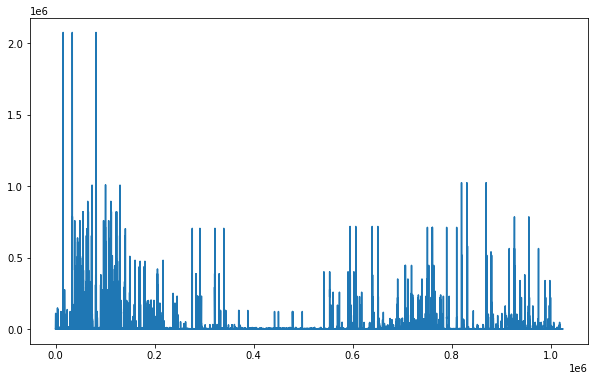

In [9]:
# 202209월 데이터
plt.figure(figsize=(10,6))
df['population_per_sns'].plot()
plt.show()

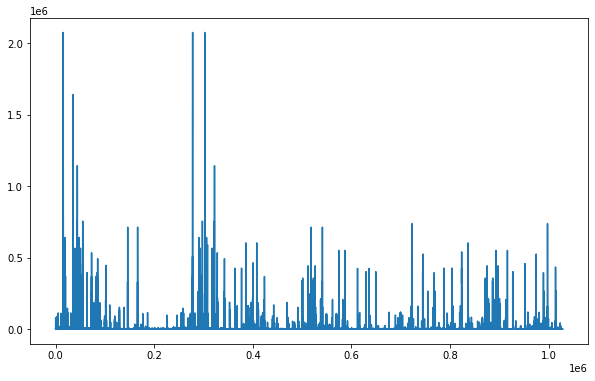

In [17]:
# 202203월 데이터
plt.figure(figsize=(10,6))
df['population_per_sns'].plot()
plt.show()

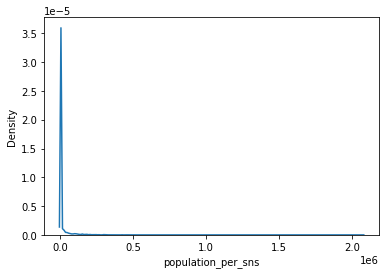

In [16]:
# 데이터 분포 확인
import seaborn as sns

sns.kdeplot(df['population_per_sns'])
plt.show()

### test

###### ver1 (틀)

In [ ]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

# 인스타그램 게시글 수 가져오기
sql = 'select * from m1.instagram_emd_cnt'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_instagram = pd.DataFrame(rows)
df_instagram.columns = ['emd_nm','emd_cd','cnt','base_ym']
df_instagram['cnt'] = df_instagram['cnt'].astype(float)

# 거주 인구 (법정동 단위)
sql = 'select emd_cd, l_tot from m2.cremao_local_population'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_cremao_local_population = pd.DataFrame(rows)
df_cremao_local_population.columns = ['emd_cd','l_tot']
df_cremao_local_population['emd_cd'] = df_cremao_local_population['emd_cd'] + '00'
df_cremao_local_population['l_tot']  = df_cremao_local_population['l_tot'].astype(float)


# 데이터 프레임 병합
df = pd.merge(df_instagram, df_cremao_local_population, on='emd_cd', how='left')

# 인구가 0명이면 제외
idx_tot = df[df['l_tot']==0].index
df = df.drop(idx_tot).reset_index(drop=True)

# 게시글 수 없는 지역 제외
idx_nm = df[(df['emd_nm']=='구호동') | (df['emd_nm']=='법성면') | (df['emd_nm']=='대소원면')].index
df = df.drop(idx_nm).reset_index(drop=True)

df['calculate'] = (df['l_tot'] / df['cnt']) * 100
df = df[(df['calculate']>=5) & (df['calculate']<=350)].reset_index(drop=True)
df = df[['emd_nm','emd_cd','calculate','base_ym']]

###### ver2 (거주인구)

In [ ]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

# 인스타그램 노출 수 가져오기
sql = 'select * from m1.instagram_emd_cnt'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_instagram = pd.DataFrame(rows)
df_instagram.columns = ['emd_nm','emd_cd','cnt','base_ym']
df_instagram['cnt'] = df_instagram['cnt'].astype(float)

# 거주 인구 (법정동 단위)
sql = 'select emd_cd, l_tot from m2.cremao_local_population'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_cremao_local_population = pd.DataFrame(rows)
df_cremao_local_population.columns = ['emd_cd','l_tot']
df_cremao_local_population['emd_cd'] = df_cremao_local_population['emd_cd'] + '00'
df_cremao_local_population['l_tot']  = df_cremao_local_population['l_tot'].astype(float)


# 데이터 프레임 병합
df = pd.merge(df_instagram, df_cremao_local_population, on='emd_cd', how='left')

# 인구가 0명이면 제외
idx_tot = df[df['l_tot']==0].index
df = df.drop(idx_tot).reset_index(drop=True)

# 게시글 수 없는 지역 제외
idx_nm = df[(df['emd_nm']=='구호동') | (df['emd_nm']=='법성면') | (df['emd_nm']=='대소원면')].index
df = df.drop(idx_nm).reset_index(drop=True)

# 유동인구 / sns 노출 수
df['population_per_sns'] = (df['l_tot'] / df['cnt'])
df = df[['emd_nm','emd_cd','population_per_sns','base_ym']]


### 2. DB INSERT
import datetime

table = 'm2.datadam_floating_population_per_sns'

# execute_mogrify
def execute_mogrify(conn, df, table, val):
    # Create a list of tuples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL query to execute
    cursor = conn.cursor()
    # drop & create
    cursor.execute(
    """
    drop table if exists m2.datadam_floating_population_per_sns;
    create table m2.datadam_floating_population_per_sns (    
    emd_nm varchar(50)
    , emd_cd varchar(10)
    , population_per_sns double precision
    , base_ym varchar(6)
    )
    distkey(emd_cd)
    compound sortkey(emd_nm, base_ym);
    commit;
    """
    )
    values = [cursor.mogrify(val, tup).decode('utf8') for tup in
              tuples]
    query = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)

    try:
        cursor.execute(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    cursor.close()

# values 설정
val = '(' + ('%s,' * len(df.columns))[:-1] + ')'

# insert
for j in range(0, len(df), 10000):

    # DB Connect
    conn = psycopg2.connect(
        host='redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
        port=5439,
        dbname='dev',
        user='awsuser',
        password='cremaoAdmin1234qwer!!'
    )

    # 10000개 단위로 나누기
    tmp = df[j:j + 10000]

    # insert
    execute_mogrify(conn, tmp, table, val)
    print(datetime.datetime.now(), ' : ', j)
    tmp = pd.DataFrame()

# row count
print(len(df))

In [1]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

In [2]:
# 인스타그램 게시글 수 가져오기
sql = 'select * from m1.instagram_emd_cnt'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_instagram = pd.DataFrame(rows)
df_instagram.columns = ['emd_nm','emd_cd','cnt','base_ym']
df_instagram['cnt'] = df_instagram['cnt'].astype(float)

In [4]:
df_instagram

,emd_nm,emd_cd,cnt,base_ym
0,가남읍,4167025000,5598,202210
1,가대동,3120010400,4728,202210
2,가락동,1171010700,4146,202210
3,가례면,4872031000,2385,202210
4,가북면,4888041000,2731,202210
...,...,...,...,...
3963,흑산면,4691036000,3135,202210
3964,흑석동,2920012400,43771,202210
3965,흑암동,4518012300,48,202210
3966,흥각동,4725011700,2015,202210


In [3]:
# 거주 인구 (법정동 단위)
sql = 'select emd_cd, l_tot from m2.cremao_local_population'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_cremao_local_population = pd.DataFrame(rows)
df_cremao_local_population.columns = ['emd_cd','l_tot']
df_cremao_local_population['emd_cd'] = df_cremao_local_population['emd_cd'] + '00'
df_cremao_local_population['l_tot']  = df_cremao_local_population['l_tot'].astype(float)

In [45]:
df_cremao_local_population

,emd_cd,l_tot
0,1111010100,3214.0000
1,1111010200,14541.0000
2,1111010300,989.0000
3,1111010400,11195.0000
4,1111010500,7929.0000
...,...,...
5049,5013025000,203.0000
5050,5013025300,78.0000
5051,5013025900,120.0000
5052,5013031000,88.0000


In [46]:
# 데이터 프레임 병합
df = pd.merge(df_instagram, df_cremao_local_population, on='emd_cd', how='left')

# 인구가 0명이면 제외
idx_tot = df[df['l_tot']==0].index
df = df.drop(idx_tot).reset_index(drop=True)

# 게시글 수 없는 지역 제외
idx_nm = df[(df['emd_nm']=='구호동') | (df['emd_nm']=='법성면') | (df['emd_nm']=='대소원면')].index
df = df.drop(idx_nm).reset_index(drop=True)

df['population_per_sns'] = (df['l_tot'] / df['cnt'])
df = df[['emd_nm','emd_cd','population_per_sns','base_ym']]

In [47]:
df['test'] = df['population_per_sns']*100

In [48]:
# 평균
df['test'].mean(axis=0)

1009.6299890828795

In [42]:
# 평균
df['population_per_sns'].mean(axis=0)

10.096299890828796

In [36]:
# 표준편차
df['population_per_sns'].std(axis=0)

70.32321040593668

In [30]:
# 표준편차 2
np.std(df['population_per_sns'], axis=0)

70.31420788264485

In [28]:
# 표준편차 3
df['population_per_sns'].values.std(axis=0)

70.31420788264485

In [39]:
df['population_per_sns'].describe()

count   3906.0000
mean      10.0963
std       70.3232
min        0.0000
25%        0.0118
50%        0.0816
75%        0.9205
max     2356.0000
Name: population_per_sns, dtype: float64

In [49]:
df.sort_values('population_per_sns',ascending=True)

,emd_nm,emd_cd,cnt,base_ym,l_tot,population_per_sns,test
2874,서면,4283031000,13417268.0000,202210,9.0000,0.0000,0.0001
2538,망상동,4217012900,13442596.0000,202210,86.0000,0.0000,0.0006
333,금고동,3020014800,99317.0000,202210,1.0000,0.0000,0.0010
1857,청풍동,2917012200,2929119.0000,202210,47.0000,0.0000,0.0016
1577,이인면,4415031000,1769228.0000,202210,43.0000,0.0000,0.0024
...,...,...,...,...,...,...,...
2067,화곡동,1150010300,41.0000,202210,31045.0000,757.1951,75719.5122
1339,영등포동1가,1156010200,63.0000,202210,52659.0000,835.8571,83585.7143
869,부용동2가,2614010800,39.0000,202210,34154.0000,875.7436,87574.3590
2349,당산동5가,1156011500,31.0000,202210,39584.0000,1276.9032,127690.3226


###### ver3 (유동인구)

In [ ]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

# 인스타그램 노출 수 가져오기
sql = 'select * from m1.instagram_emd_cnt'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_instagram = pd.DataFrame(rows)
df_instagram.columns = ['emd_nm','emd_cd','cnt','base_ym']
df_instagram['cnt'] = df_instagram['cnt'].astype(float)

# 법정동별 유동인구 
sql = '''
    select substring (pnu, 0, 11), sum(f_tot)
      from m2.cremao_land_floating_population
     group by substring (pnu, 0, 11)
'''
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_f_tot = pd.DataFrame(rows)
df_f_tot.columns = ['emd_cd','f_tot']


# 데이터 프레임 병합
df = pd.merge(df_instagram, df_f_tot, on='emd_cd', how='left')

# 인구가 0, null 인 지역 제외
df = df[~df['f_tot'].isnull()].reset_index(drop=True)

# 게시글 수 없는 지역 제외
idx_nm = df[(df['emd_nm']=='구호동') | (df['emd_nm']=='법성면') | (df['emd_nm']=='대소원면')].index
df = df.drop(idx_nm).reset_index(drop=True)

# 유동인구 / sns 노출 수
df['population_per_sns'] = (df['f_tot'] / df['cnt'])
df = df[['emd_nm','emd_cd','population_per_sns','base_ym']]


### 2. DB INSERT
import datetime

table = 'm2.datadam_floating_population_per_sns'

# execute_mogrify
def execute_mogrify(conn, df, table, val):
    # Create a list of tuples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL query to execute
    cursor = conn.cursor()
    # drop & create
    cursor.execute(
    """
    drop table if exists m2.datadam_floating_population_per_sns;
    create table m2.datadam_floating_population_per_sns (    
    emd_nm varchar(50)
    , emd_cd varchar(10)
    , population_per_sns double precision
    , base_ym varchar(6)
    )
    distkey(emd_cd)
    compound sortkey(emd_nm, base_ym);
    commit;
    """
    )
    values = [cursor.mogrify(val, tup).decode('utf8') for tup in
              tuples]
    query = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)

    try:
        cursor.execute(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    cursor.close()

# values 설정
val = '(' + ('%s,' * len(df.columns))[:-1] + ')'

# insert
for j in range(0, len(df), 10000):

    # DB Connect
    conn = psycopg2.connect(
        host='redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
        port=5439,
        dbname='dev',
        user='awsuser',
        password='cremaoAdmin1234qwer!!'
    )

    # 10000개 단위로 나누기
    tmp = df[j:j + 10000]

    # insert
    execute_mogrify(conn, tmp, table, val)
    print(datetime.datetime.now(), ' : ', j)
    tmp = pd.DataFrame()

# row count
print(len(df))

In [51]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

# 인스타그램 노출 수 가져오기
sql = 'select * from m1.instagram_emd_cnt'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_instagram = pd.DataFrame(rows)
df_instagram.columns = ['emd_nm','emd_cd','cnt','base_ym']
df_instagram['cnt'] = df_instagram['cnt'].astype(float)

In [52]:
# 법정동별 유동인구 
sql = '''
    select substring (pnu, 0, 11), sum(f_tot)
      from m2.cremao_land_floating_population
     group by substring (pnu, 0, 11)
'''
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_f_tot = pd.DataFrame(rows)
df_f_tot.columns = ['emd_cd','f_tot']

In [62]:
# 데이터 프레임 병합
df = pd.merge(df_instagram, df_f_tot, on='emd_cd', how='left')

# 인구가 0, null 인 지역 제외
df = df[~df['f_tot'].isnull()].reset_index(drop=True)

# 게시글 수 없는 지역 제외
idx_nm = df[(df['emd_nm']=='구호동') | (df['emd_nm']=='법성면') | (df['emd_nm']=='대소원면')].index
df = df.drop(idx_nm).reset_index(drop=True)

# 유동인구 / sns 노출 수
df['population_per_sns'] = (df['f_tot'] / df['cnt'])
df = df[['emd_nm','emd_cd','population_per_sns','base_ym']]

In [71]:
df.describe()

,population_per_sns
count,2740.0000
mean,159831.1659
std,1745138.9982
min,0.0018
25%,147.8487
50%,1760.2928
75%,10684.0628
max,56944160.5854


In [67]:
df.sort_values('population_per_sns', ascending=True)

,emd_nm,emd_cd,population_per_sns,base_ym
1524,구완동,3014012100,0.0018,202210
1297,청풍동,2917012200,0.0031,202210
2403,이기동,4217012500,0.0031,202210
1290,청소면,4418034000,0.0050,202210
225,금고동,3020014800,0.0058,202210
...,...,...,...,...
2333,우동,2635010500,17912835.1842,202210
2156,신월동,1147010300,20173083.0000,202210
204,구로동,1153010200,25675983.3393,202210
1987,상계동,1135010500,49390350.6667,202210


###### ver4 (PNU 단위)

In [1]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

# 인스타그램 노출 수 가져오기
sql = 'select * from m1.instagram_emd_cnt'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_instagram = pd.DataFrame(rows)
df_instagram.columns = ['emd_nm','emd_cd','cnt','base_ym']
df_instagram['cnt'] = df_instagram['cnt'].astype(float)

# 법정동별 유동인구 
sql = 'select pnu, f_tot from m2.cremao_land_floating_population'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_f_tot = pd.DataFrame(rows)
df_f_tot.columns = ['pnu','f_tot']
df_f_tot['emd_cd'] = df_f_tot['pnu'].str[:10]

# 데이터 프레임 병합
df = pd.merge(df_instagram, df_f_tot, on='emd_cd', how='left')

# 인구가 0, null 인 지역 제외
df = df[~df['f_tot'].isnull()].reset_index(drop=True)

# 게시글 수 없는 지역 제외
idx_nm = df[(df['emd_nm']=='구호동') | (df['emd_nm']=='법성면') | (df['emd_nm']=='대소원면')].index
df = df.drop(idx_nm).reset_index(drop=True)

# 유동인구 / sns 노출 수
df['population_per_sns'] = (df['f_tot'] / df['cnt'])
df = df[['emd_nm','emd_cd','pnu','population_per_sns','base_ym']]


### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

# 인스타그램 노출 수 가져오기
sql = 'select * from m1.instagram_emd_cnt'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_instagram = pd.DataFrame(rows)
df_instagram.columns = ['emd_nm','emd_cd','cnt','base_ym']
df_instagram['cnt'] = df_instagram['cnt'].astype(float)

# 법정동별 유동인구 
sql = 'select pnu, f_tot from m2.cremao_land_floating_population'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_f_tot = pd.DataFrame(rows)
df_f_tot.columns = ['pnu','f_tot']
df_f_tot['emd_cd'] = df_f_tot['pnu'].str[:10]

# 데이터 프레임 병합
df = pd.merge(df_instagram, df_f_tot, on='emd_cd', how='left')

# 인구가 0, null 인 지역 제외
df = df[~df['f_tot'].isnull()].reset_index(drop=True)

# 게시글 수 없는 지역 제외
idx_nm = df[(df['emd_nm']=='구호동') | (df['emd_nm']=='법성면') | (df['emd_nm']=='대소원면')].index
df = df.drop(idx_nm).reset_index(drop=True)

# 유동인구 / sns 노출 수
df['population_per_sns'] = (df['f_tot'] / df['cnt'])
df = df[['emd_nm','emd_cd','pnu','population_per_sns','base_ym']]


### 2. DB INSERT
import datetime

table = 'm2.datadam_floating_population_per_sns'

# execute_mogrify
def execute_mogrify(conn, df, table, val):
    # Create a list of tuples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL query to execute
    cursor = conn.cursor()
    # drop & create
    cursor.execute(
    """
    drop table if exists m2.datadam_floating_population_per_sns;
    create table m2.datadam_floating_population_per_sns (    
    emd_nm varchar(50)
    , emd_cd varchar(10)
    , pnu varchar(19)
    , population_per_sns double precision
    , base_ym varchar(6)
    )
    distkey(emd_cd)
    compound sortkey(emd_nm, pnu, base_ym);
    commit;
    """
    )
    values = [cursor.mogrify(val, tup).decode('utf8') for tup in
              tuples]
    query = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)

    try:
        cursor.execute(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    cursor.close()

# values 설정
val = '(' + ('%s,' * len(df.columns))[:-1] + ')'

# insert
for j in range(0, len(df), 10000):

    # DB Connect
    conn = psycopg2.connect(
        host='redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
        port=5439,
        dbname='dev',
        user='awsuser',
        password='cremaoAdmin1234qwer!!'
    )

    # 10000개 단위로 나누기
    tmp = df[j:j + 10000]

    # insert
    execute_mogrify(conn, tmp, table, val)
    print(datetime.datetime.now(), ' : ', j)
    tmp = pd.DataFrame()

# row count
print(len(df))

In [14]:
df

,emd_nm,emd_cd,pnu,population_per_sns,base_ym
0,가락동,1171010700,1171010700100010000,71.7262,202210
1,가락동,1171010700,1171010700100010007,80.6768,202210
2,가락동,1171010700,1171010700100020001,80.6768,202210
3,가락동,1171010700,1171010700100020003,80.6768,202210
4,가락동,1171010700,1171010700100020006,73.0656,202210
...,...,...,...,...,...
325449,흑석동,2920012400,2920012400107620000,3.8584,202210
325450,흑석동,2920012400,2920012400107780000,3.8584,202210
325451,흑석동,2920012400,2920012400107790000,3.8584,202210
325452,흑석동,2920012400,2920012400107800000,3.8584,202210


In [15]:
df.describe()

,population_per_sns
count,325454.0000
mean,1062.0967
std,4412.4730
min,0.0001
25%,5.1670
50%,27.0600
75%,103.6906
max,85461.6829
